Below is code with a link to a happy or sad dataset which contains 80 images, 40 happy and 40 sad. 
Create a convolutional neural network that trains to 100% accuracy on these images,  which cancels training upon hitting training accuracy of >.999

Hint -- it will work best with 3 convolutional layers.

In [ ]:
import tensorflow as tf
import os
import zipfile


DESIRED_ACCURACY = 0.999

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>DESIRED_ACCURACY):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

--2019-05-29 07:46:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.06s   

2019-05-29 07:46:12 (42.1 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



##Data Preprocessing


In [ ]:
# This code block should create an instance of an ImageDataGenerator called train_datagen 
# And a train_generator by calling train_datagen.flow_from_directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/tmp/h-or-s/',  
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')
print(train_generator.classes[0])
# Expected output: 'Found 80 images belonging to 2 classes'

Found 80 images belonging to 2 classes.
0


Using TensorFlow backend.


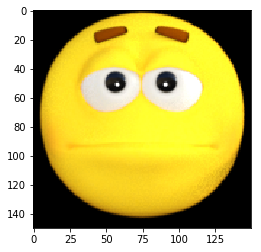

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
x,y = train_generator.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

##Training the model


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3), activation='relu', input_shape=(150, 150, 3), padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding = "same"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
])

model.summary()
from tensorflow.keras.optimizers import RMSprop
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = adam, loss='binary_crossentropy', metrics = ['acc'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flat

In [ ]:
# This code block should call model.fit_generator and train for
# a number of epochs. 
history = model.fit_generator(
      train_generator,
      steps_per_epoch=5,  
      epochs=15,
      verbose=1,
      callbacks=[callbacks])

model.save('keras_saved_model.h5')
# Expected output: "Reached 99.9% accuracy so cancelling training!""

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
80/80 [==============================] - 4s 47ms/step - loss: 0.7885 - acc: 0.6375
Epoch 2/15
80/80 [==============================] - 1s 13ms/step - loss: 0.4959 - acc: 0.8125
Epoch 3/15
80/80 [==============================] - 1s 14ms/step - loss: 0.1464 - acc: 0.9500
Epoch 4/15
80/80 [==============================] - 1s 13ms/step - loss: 0.0463 - acc: 0.9875
Epoch 5/15
76/80 [===========================>..] - ETA: 0s - loss: 0.0108 - acc: 1.0000
Reached 99.9% accuracy so cancelling training!
80/80 [==============================] - 1s 14ms/step - loss: 0.0133 - acc: 1.0000


##Running the Model

In [ ]:
%%writefile model_prediction.py
import pickle
import os
import numpy as np

class CustomModelPrediction(object):

  def __init__(self, model):
    self._model = model
  
  def predict(self, instances, **kwargs):
    predictions = self._model.predict(instances)
    return predictions.tolist()

  @classmethod
  def from_path(cls, model_dir):
    import tensorflow.keras as keras
    model = keras.models.load_model(
      os.path.join(model_dir,'keras_saved_model.h5'))

    return cls(model)

Overwriting model_prediction.py


Saving smiley-163510_640.jpg to smiley-163510_640 (4).jpg
Saving smiley-1635448_640.png to smiley-1635448_640 (1).png
[[1.0]]
Predicted labels:
smiley-163510_640.jpg is happy
[[3.8158701452348985e-22]]
Predicted labels:
smiley-1635448_640.png is sad


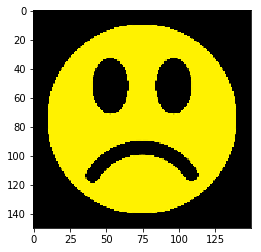

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from model_prediction import CustomModelPrediction

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classifier = CustomModelPrediction.from_path('.')
  results = classifier.predict(images)
  print(results)
  for i in range(len(results)):
    print('Predicted labels:')
    for idx,val in enumerate(results[i]):
      if val >0.5:
         print(fn + " is happy")
      else:
         print(fn + " is sad")
 

## Visualizing Intermediate Representations

In [ ]:
# Directory with our training horse pictures
train_happy_dir = os.path.join('/tmp/h-or-s/happy')

# Directory with our training human pictures
train_sad_dir = os.path.join('/tmp/h-or-s/sad')

train_happy_names = os.listdir(train_happy_dir)
train_sad_names = os.listdir(train_sad_dir)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


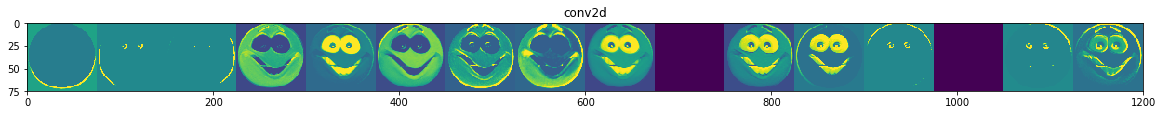

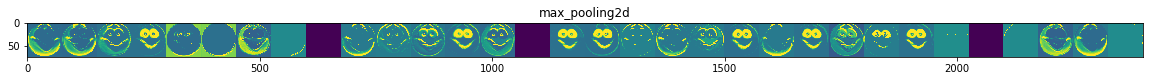

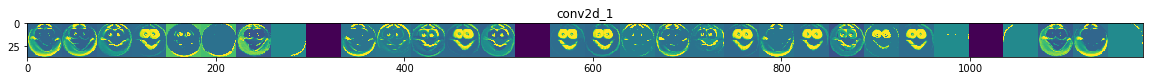

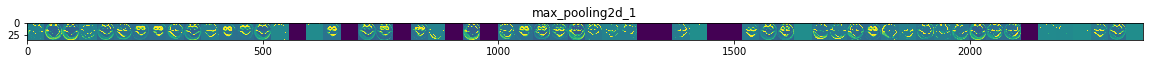

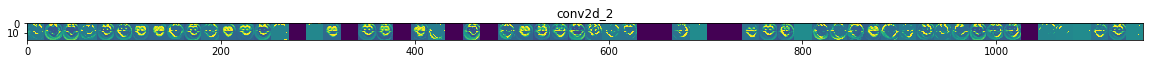

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
happy_img_files = [os.path.join(train_happy_dir, f) for f in train_happy_names]
sad_img_files = [os.path.join(train_sad_dir, f) for f in train_sad_names]
img_path = random.choice(happy_img_files + sad_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

##Deploy Model to AI Platform


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
%%writefile setup.py

from setuptools import setup

setup(
  name="so_predict",
  version="0.1",
  include_package_data=True,
  scripts=["model_prediction.py"]
)

Writing setup.py


In [ ]:
## Replace this with the name of your Cloud Storage bucket

!gsutil cp keras_saved_model.h5 gs://your_gcs_bucket/

Copying file://keras_saved_model.h5 [Content-Type=application/octet-stream]...
ResumableUploadAbortException: 403 The project to be billed is associated with a closed billing account.


In [ ]:
# Replace with your bucket name below
!python setup.py sdist
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://your_gcs_bucket/packages/so_predict-0.1.tar.gz

running sdist
running egg_info
creating so_predict.egg-info
writing so_predict.egg-info/PKG-INFO
writing dependency_links to so_predict.egg-info/dependency_links.txt
writing top-level names to so_predict.egg-info/top_level.txt
writing manifest file 'so_predict.egg-info/SOURCES.txt'
reading manifest file 'so_predict.egg-info/SOURCES.txt'
writing manifest file 'so_predict.egg-info/SOURCES.txt'

running check


creating so_predict-0.1
creating so_predict-0.1/so_predict.egg-info
copying files to so_predict-0.1...
copying model_prediction.py -> so_predict-0.1
copying setup.py -> so_predict-0.1
copying so_predict.egg-info/PKG-INFO -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/SOURCES.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/dependency_links.txt -> so_predict-0.1/so_predict.egg-info
copying so_predict.egg-info/top_level.txt -> so_predict-0.1/so_predict.egg-info
Writing so_predict-0.1/setup.cfg
creating dist
Creating tar archive
removing 'so_pre

In [ ]:
# Replace with your Cloud project name
!gcloud config set project your-cloud-project

In [ ]:
# Create model if it hasn't been created yet
!gcloud ml-engine models create your_model_name

In [ ]:
# To use this custom code feature, fill out this form: bit.ly/cmle-custom-code-signup
!gcloud alpha ml-engine versions create v1 --model your_model_name \
--origin=gs://your_gcs_bucket/ \
--python-version=3.5 \
--runtime-version=1.13 \
--framework='TENSORFLOW' \
--package-uris=gs://your_gcs_bucket/packages/so_predict-0.1.tar.gz \
--model-class=model_prediction.CustomModelPrediction

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from model_prediction import CustomModelPrediction

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])

In [ ]:
predictions = !gcloud ml-engine predict --model='your_model_name' --text-instances=images --version=v1
print(predictions)

In [ ]:
for i in range(len(predictions)):
    print('Predicted labels:')
    for idx,val in enumerate(predictions[i]):
      if val >0.5:
         print(fn + " is happy")
      else:
         print(fn + " is sad")